/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🎬 [Start] 하이브리드 AI 광고 생성 시작 (메모리 최적화 모드)

🚀 [Phase 1] 누끼 작업 시작...
🧹 [Memory] VRAM Cleaned.


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


🧹 [Memory] VRAM Cleaned.

🚀 [Phase 2] 배경 생성 시작...
🧹 [Memory] VRAM Cleaned.


100%|██████████| 40/40 [00:14<00:00,  2.69it/s]


🧹 [Memory] VRAM Cleaned.

🚀 [Phase 3] 파이썬 합성 및 텍스트 배치 (AI 효과 전 단계)...

🚀 [Phase 4] AI 통합 리터칭 (텍스트에 효과 입히기)...
🧹 [Memory] VRAM Cleaned.


100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


🧹 [Memory] VRAM Cleaned.


/tmp/ipykernel_89678/1234975251.py:68: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/1234975251.py:68: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/1234975251.py:68: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/1234975251.py:68: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/1234975251.py:68: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/1234975251.py:68: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/1234975251.py:68: UserWarning: Glyph 53581 (\N{HANGUL SYLLABLE TEG}) missing from font(s) DejaVu Sans.
  p

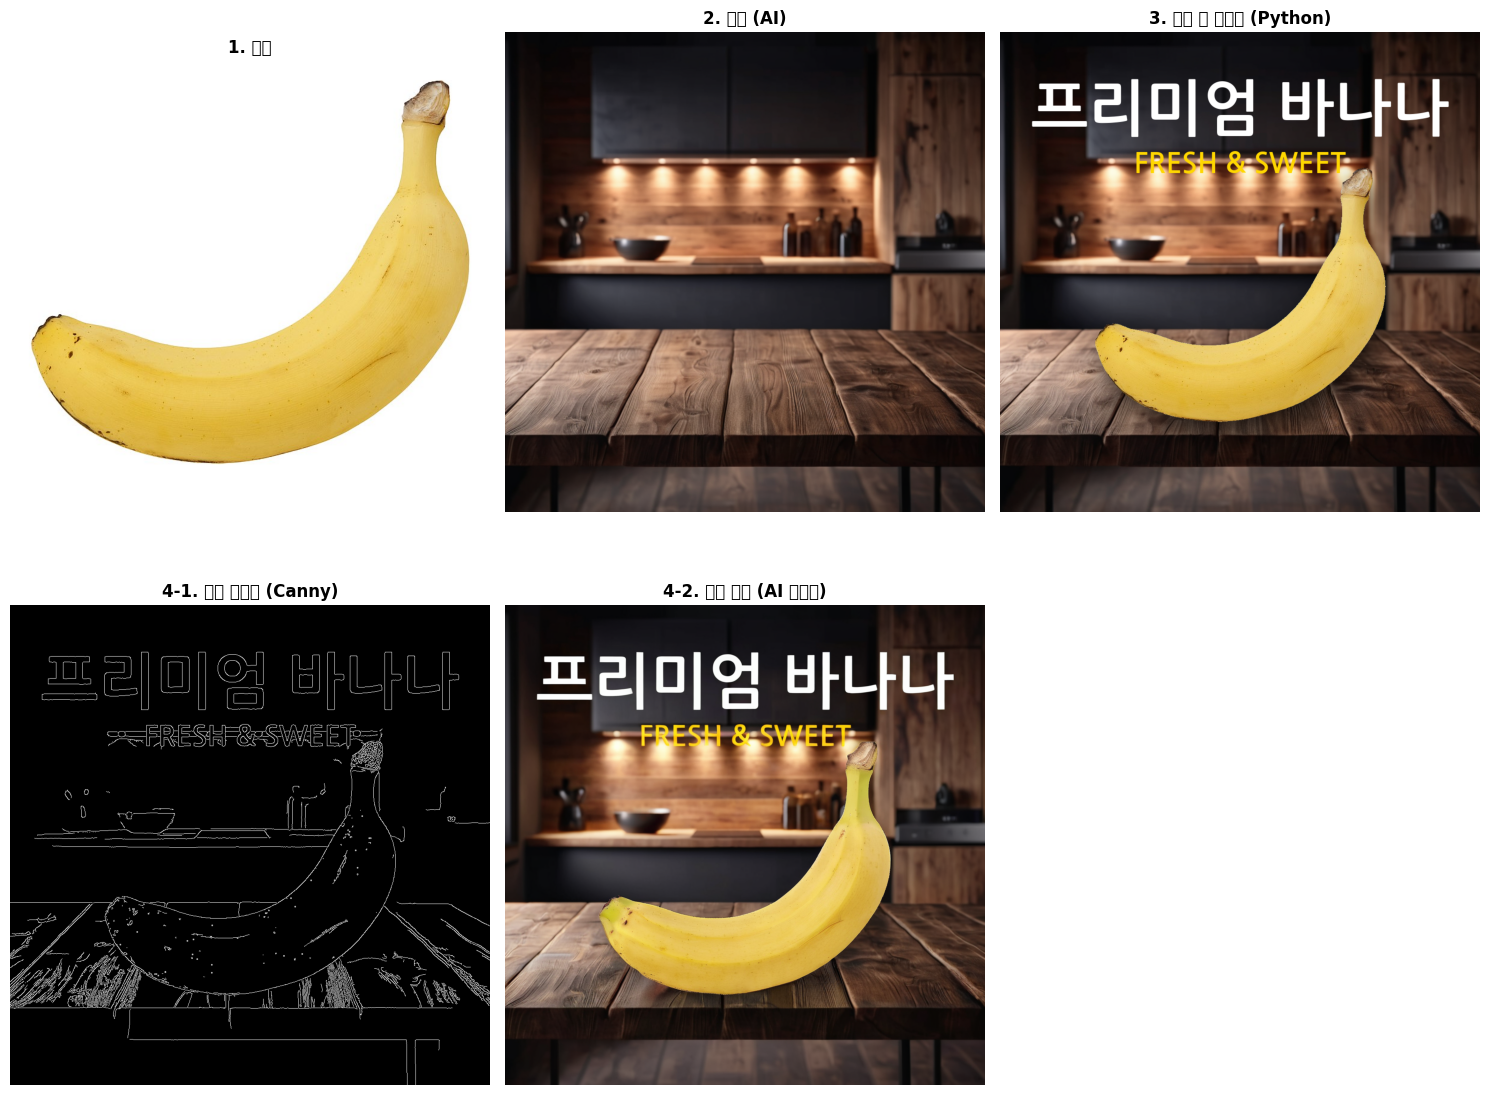

In [1]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import cv2
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from diffusers import (
    StableDiffusionXLControlNetImg2ImgPipeline,
    ControlNetModel,
    AutoencoderKL,
    AutoPipelineForText2Image,
    DPMSolverMultistepScheduler
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import math

# ==========================================
# ⚙️ 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.float16

# 모델 ID 정의
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "BASE": "RunDiffusion/Juggernaut-XL-v9",
    "VAE": "madebyollin/sdxl-vae-fp16-fix",
    "CONTROLNET": "diffusers/controlnet-canny-sdxl-1.0"
}

def flush():
    """VRAM 메모리 완전 초기화 (가장 중요)"""
    gc.collect()
    torch.cuda.empty_cache()
    print("🧹 [Memory] VRAM Cleaned.")

def download_font(font_name="NanumGothicBold.ttf"):
    url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
    if not os.path.exists(font_name) or os.path.getsize(font_name) < 1000:
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def get_canny_edge(image):
    """이미지 윤곽선 추출 (텍스트와 객체 형태 유지용)"""
    image = np.array(image)
    # 텍스트가 포함되면 디테일하게 따기 위해 임계값 조정
    image = cv2.Canny(image, 50, 150) 
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    return Image.fromarray(image)

def plot_steps(step_images):
    n = len(step_images)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(15, 6 * rows))
    for i, (img, title) in enumerate(step_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# 🛠️ [Phase 1] 객체 누끼 (모델 로드/언로드)
# ==========================================
def run_segmentation(image_path):
    print("\n🚀 [Phase 1] 누끼 작업 시작...")
    flush()
    
    # 모델 로드
    model = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    )
    model.to(DEVICE)
    model.eval()

    # 처리
    img = load_image(image_path).convert("RGB")
    W, H = img.size
    img_input = img.resize((1024, 1024), Image.LANCZOS)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_input).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        preds = model(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 120 else 0)
    
    foreground = img.copy()
    foreground.putalpha(mask)
    
    # 모델 삭제 및 메모리 해제
    del model, input_tensor
    flush()
    
    return img, foreground, mask

# ==========================================
# 🛠️ [Phase 2] 배경 생성 (모델 로드/언로드)
# ==========================================
def run_bg_generation():
    print("\n🚀 [Phase 2] 배경 생성 시작...")
    flush()
    
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["VAE"], torch_dtype=TORCH_DTYPE).to(DEVICE)
    pipe = AutoPipelineForText2Image.from_pretrained(
        MODEL_IDS["BASE"], torch_dtype=TORCH_DTYPE, variant="fp16", vae=vae
    ).to(DEVICE)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)
    
    # 💡 텍스트가 잘 보일 수 있는 '여백이 있는' 구도 요청
    prompt = (
        "Professional product photography, empty rustic wooden table surface, "
        "dark blurred kitchen background, cinematic lighting from left, "
        "minimalist composition, high contrast, 8k, masterpiece"
    )
    negative = "messy, cluttered, bright, text, watermark"
    
    bg = pipe(
        prompt=prompt, negative_prompt=negative,
        width=1024, height=1024, num_inference_steps=40, guidance_scale=7.0
    ).images[0]
    
    del pipe, vae
    flush()
    return bg

# ==========================================
# 🛠️ [Phase 3] 파이썬 합성 & 텍스트 배치 (CPU 작업)
# ==========================================
def run_manual_composition(bg, fg, mask):
    print("\n🚀 [Phase 3] 파이썬 합성 및 텍스트 배치 (AI 효과 전 단계)...")
    
    # 1. 객체 합성
    bg_w, bg_h = bg.size
    fg_w, fg_h = fg.size
    scale = 0.85
    new_w, new_h = int(fg_w * scale), int(fg_h * scale)
    
    fg_resized = fg.resize((new_w, new_h), Image.LANCZOS)
    mask_resized = mask.resize((new_w, new_h), Image.LANCZOS)
    
    # 객체 위치 (중앙 하단)
    obj_x = (bg_w - new_w) // 2
    obj_y = (bg_h - new_h) // 2 + 50
    
    # 그림자 생성
    shadow = Image.new("RGBA", bg.size, (0,0,0,0))
    shadow.paste((0,0,0,200), (obj_x+15, obj_y+25), mask=mask_resized)
    shadow = shadow.filter(ImageFilter.GaussianBlur(30))
    
    # 합성
    comp = bg.convert("RGBA")
    comp = Image.alpha_composite(comp, shadow)
    
    fg_layer = Image.new("RGBA", bg.size, (0,0,0,0))
    fg_layer.paste(fg_resized, (obj_x, obj_y), mask=fg_resized)
    comp = Image.alpha_composite(comp, fg_layer)
    
    # 2. 텍스트 배치 (여기서는 단순 흰색/노란색으로 배치만 함)
    # 나중에 AI가 이 텍스트를 인식해서 '빛나는 효과'나 '입체감'을 줄 것임
    draw = ImageDraw.Draw(comp)
    font_path = download_font()
    
    # 폰트 크기 및 내용
    main_text = "프리미엄 바나나"
    sub_text = "FRESH & SWEET"
    
    font_main = ImageFont.truetype(font_path, 130)
    font_sub = ImageFont.truetype(font_path, 60)
    
    # 위치 계산 (상단 중앙)
    def get_pos(text, font, y_offset):
        bbox = draw.textbbox((0,0), text, font=font)
        w = bbox[2] - bbox[0]
        return ((bg_w - w) // 2, y_offset)

    draw.text(get_pos(main_text, font_main, 100), main_text, font=font_main, fill="white")
    draw.text(get_pos(sub_text, font_sub, 250), sub_text, font=font_sub, fill="#FFD700") # Gold color
    
    return comp.convert("RGB")

# ==========================================
# 🛠️ [Phase 4] AI 통합 리터칭 (텍스트 디자인 포함)
# ==========================================
def run_final_refinement(composite_image):
    print("\n🚀 [Phase 4] AI 통합 리터칭 (텍스트에 효과 입히기)...")
    flush()
    
    # Canny 맵 생성 (글자와 객체의 '윤곽'을 땀)
    # AI는 이 윤곽선 안쪽을 채색하는 역할을 하게 됨
    canny_map = get_canny_edge(composite_image)
    
    # 모델 로드 (ControlNet 포함)
    controlnet = ControlNetModel.from_pretrained(MODEL_IDS["CONTROLNET"], torch_dtype=TORCH_DTYPE).to(DEVICE)
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["VAE"], torch_dtype=TORCH_DTYPE).to(DEVICE)
    pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
        MODEL_IDS["BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE, variant="fp16"
    ).to(DEVICE)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)
    
    # 💡 프롬프트 전략:
    # "3d render text", "glowing text" 등을 추가하여 
    # 파이썬으로 쓴 평범한 텍스트를 AI가 디자인된 텍스트로 인식하게 유도
    prompt = (
        "Professional product advertisement, premium banana on table, "
        "hyperrealistic, cinematic lighting, "
        "3d rendered white text, golden subtext, glowing typography, " # 텍스트 효과 지시
        "embossed text effect, high quality, 8k"
    )
    negative = "low quality, blur, distortion, messy text, typos"
    
    final = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=composite_image,         # 원본 색상 참조
        control_image=canny_map,       # 형태 고정 (글자 깨짐 방지)
        strength=0.35,                 # 0.3~0.4: 글자 형태는 유지하되 질감만 바꿈
        controlnet_conditioning_scale=1.0, # 형태 강제 고정
        num_inference_steps=50,
        guidance_scale=8.0
    ).images[0]
    
    del pipe, controlnet, vae
    flush()
    return final, canny_map

# ==========================================
# 🚀 메인 파이프라인
# ==========================================
def process_hybrid_ad(image_path):
    print("🎬 [Start] 하이브리드 AI 광고 생성 시작 (메모리 최적화 모드)")
    step_images = []
    
    # 1. 누끼
    orig, fg, mask = run_segmentation(image_path)
    step_images.append((orig, "1. 원본"))
    
    # 2. 배경
    bg = run_bg_generation()
    step_images.append((bg, "2. 배경 (AI)"))
    
    # 3. 파이썬 합성 (텍스트 포함)
    # 여기서 텍스트는 그냥 평범한 폰트로 들어감
    draft_comp = run_manual_composition(bg, fg, mask)
    step_images.append((draft_comp, "3. 배치 및 텍스트 (Python)"))
    
    # 4. 최종 리터칭 (텍스트 디자인화)
    # AI가 3번 이미지를 보고 "어, 여기 글자가 있네? 예쁘게 만들어야지"라고 처리함
    final_result, canny = run_final_refinement(draft_comp)
    step_images.append((canny, "4-1. 형태 가이드 (Canny)"))
    step_images.append((final_result, "4-2. 최종 결과 (AI 리터칭)"))
    
    final_result.save("final_hybrid_ad.png")
    plot_steps(step_images)

# 실행
process_hybrid_ad("image.png")